# Cross-section energy loss correction

In [1]:
import pandas as pd
import sys
sys.path.append('..')

from spyral.core.constants import QBRHO_2_P
from spyral.core.run_stacks import form_run_string

from spyral_utils.nuclear import NuclearDataMap
from spyral_utils.nuclear.target import GasTarget, load_target
from spyral_utils.plot import Histogrammer

from pathlib import Path
from scipy.constants import physical_constants, torr
from scipy.stats import iqr
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import vector
import lmfit

%matplotlib widget

In [2]:
run_min = 53
run_max = 169

workspace_path = Path("/Volumes/researchEXT/O16/no_efield")
target_material_path = Path("/Users/pranjalsingh/Desktop/research_space_spyral/e20020_analysis/solver_gas_16O.json")

solver_result_path = workspace_path / "InterpSolver"
beam_events_path = workspace_path / "beam_events"

## Reaction properties

In [3]:
proj_energy_start = 160
# Units of MeV. Initial beam energy

ejectile_z = 2
ejectile_a = 4

projectile_z = 8
projectile_a = 16

target_z = 2
target_a = 4

residual_z = target_z + projectile_z - ejectile_z
residual_a = target_a + projectile_a - ejectile_a

if residual_z < 0:
    raise Exception(f"Illegal nuclei! Residual Z: {residual_z}")
if residual_a < 1:
    raise Exception(f"Illegal nuclei! Residual A: {residual_a}")

In [4]:
nuclear_map = NuclearDataMap()

target_material = load_target(target_material_path, nuclear_map)
if not isinstance(target_material, GasTarget):
    print('Target error!')


ejectile = nuclear_map.get_data(ejectile_z, ejectile_a)
projectile = nuclear_map.get_data(projectile_z, projectile_a)
target = nuclear_map.get_data(target_z, target_a)
residual = nuclear_map.get_data(residual_z, residual_a)
print(f"Reaction: {target}({projectile}, {ejectile}){residual}")
print(f"Target material: {target_material.ugly_string}")

Reaction: 4He(16O, 4He)16O
Target material: (Gas)4He1


## Defining gas properties

In [5]:
# Define parameters used for finding the cross section
boltzmann = physical_constants["Boltzmann constant"][0]    # Units of Joules / Kelvin
torr_2_pascal = torr    # Convert from torr to pascals
pressure = 700 # Units of torr
temperature = 293.15    # Units of Kelvin, room temperature
stoich = 1 # Stoichiometry of gas

## Cross-section plotting properties

In [6]:

min_z = 0.004    # Units of meters. Minimum z value of vertex (inclusive)
max_z = 0.958    # Units of meters. Maximum z value of vertex (inclusive)

min_cm = 10.0   # Units of degrees. Minimum center-of-mass scattering angle for events in excitation spectrum (inclusive)
max_cm = 60.0   # Units of degrees. Maximum center-of-mass scattering angle for events in excitation spectrum (inclusive)

hist_en_min = -3      # Smallest allowed excitation energy in histogram (inclusive)
hist_en_max = 20   # Largest allowed excitation energy in histogram (inclusive)
hist_en_bins = 150       # Number of bins in excitation energy histogram

ang_dist_bins =  25  

In [7]:
results = {}

# Add keys for result parameters
results["polar"] = np.empty(0, float)
results["kinetic_energy"] = np.empty(0, float)
results["ex_energy"] = np.empty(0, float)
results["cm_polar"] = np.empty(0, float)
results["chisq"] = np.empty(0, float)
results["z_vert"] = np.empty(0, float)
results["brho"] = np.empty(0, float)

# Create histogram tool
grammer = Histogrammer()

## Experimental kinematics

In [8]:
target_vector = vector.array({"px": [0.0], "py": [0.0], "pz": [0.0], "E": [target.mass]})

for run in range(run_min, run_max+1):

    df = None
    path = solver_result_path / f"run_{run:04d}_{ejectile.isotopic_symbol}.parquet"

    if not path.exists():
        continue
    
    df = pl.scan_parquet(path)

    df = (df.filter((pl.col("vertex_z") >= min_z) 
                    & (pl.col("vertex_z") <= max_z)
                    )
                .collect()
        )
    
    vertices = df.select(['vertex_x', 'vertex_y', 'vertex_z']).to_numpy()
    distances = np.linalg.norm(vertices, axis=1)
    projectile_ke = proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, distances)
    projectile_vector = vector.array({
            "px": np.zeros(len(projectile_ke)),
            "py": np.zeros(len(projectile_ke)),
            "pz": np.sqrt(projectile_ke * (projectile_ke + 2.0 * projectile.mass)),
            "E": projectile_ke + projectile.mass
        })
    brho = df.select('brho').to_numpy().flatten()
    momentum = df.select('brho').to_numpy().flatten() * float(ejectile.Z) * QBRHO_2_P
    kinetic_energy = np.sqrt(momentum**2.0 + ejectile.mass**2.0) - ejectile.mass
    polar = df.select('polar').to_numpy().flatten()
    az = df.select('azimuthal').to_numpy().flatten()
    ejectile_vector = vector.array({
            "px": momentum * np.sin(polar) * np.cos(az),
            "py": momentum * np.sin(polar) * np.sin(az),
            "pz": momentum * np.cos(polar),
            "E": np.sqrt(momentum**2.0 + ejectile.mass**2.0)
        })
        
    cs = df.select('redchisq').to_numpy().flatten()
    zvert=df.select('vertex_z').to_numpy().flatten()

    residual_vector = target_vector + projectile_vector - ejectile_vector # type: ignore
    ex_energy = residual_vector.mass - residual.mass # Excitation energy is "extra" mass

    cm_vec = ejectile_vector.boostCM_of(projectile_vector + target_vector)
    cm_polar = np.pi - cm_vec.theta

    results["polar"] = np.append(results["polar"], polar)
    results["kinetic_energy"] = np.append(results["kinetic_energy"], kinetic_energy)
    results["ex_energy"] = np.append(results["ex_energy"], ex_energy)
    results["cm_polar"] = np.append(results["cm_polar"], cm_polar)
    results["chisq"] = np.append(results["chisq"], cs)
    results["z_vert"] = np.append(results["z_vert"], zvert)
    results["brho"] = np.append(results["brho"],brho)


## Z-vertex plot

Overwriting histogram named z_vert in Histogrammer.add_histogram!


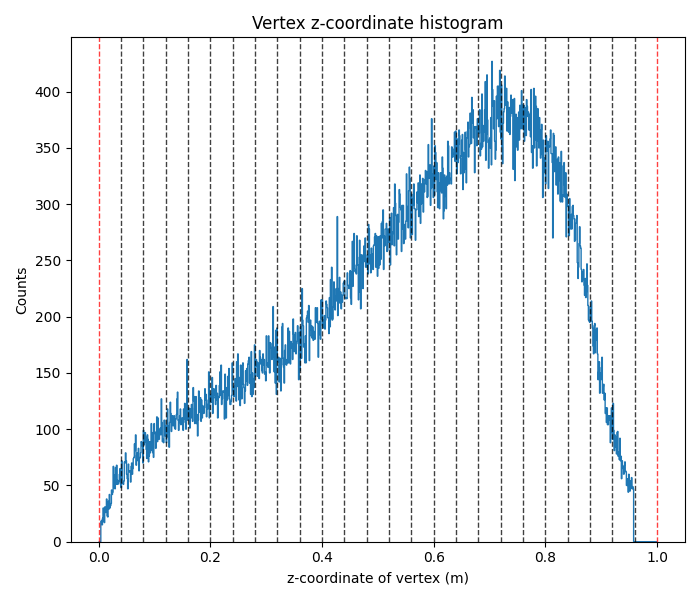

In [21]:
grammer.add_hist1d('z_vert', 1000, (0.0, 1.0))
grammer.fill_hist1d('z_vert', results["z_vert"])
vertz = grammer.get_hist1d("z_vert")

slice_val = 40
slice_bins = len(vertz.bins)//slice_val 
counts_slices = np.zeros(slice_bins)
bins_slices = np.zeros(slice_bins)
slice_idx = 0
slice_counts = 0

fig, ax = plt.subplots(1,1)
for idx, counts in enumerate(vertz.counts):
    
    if idx%slice_val == 0 and idx!=0:
        ax.axvline(vertz.bins[idx],color ='black', linestyle="--",lw = 1, alpha = 0.75)
        bins_slices[slice_idx] = vertz.bins[idx]
        counts_slices[slice_idx] = slice_counts
        slice_counts = 0 
        slice_idx +=1
        
    slice_counts+=counts

if slice_idx < slice_bins: #left over bins until 1.0 m
    bins_slices[slice_idx] = vertz.bins[-1]   
    counts_slices[slice_idx] = slice_counts
    
    
assert sum(counts_slices) == sum(vertz.counts), "Missing some counts from the overall bins"

ax.axvline(x=0,color ='red', linestyle="--",lw = 1, alpha = 0.75)
ax.axvline(x=1.0,color ='red', linestyle="--",lw = 1, alpha = 0.75)
ax.stairs(vertz.counts, edges=vertz.bins)
ax.set_title("Vertex z-coordinate histogram")
ax.set_xlabel("z-coordinate of vertex (m)")
ax.set_ylabel("Counts")
fig.set_figheight(6.0)
fig.set_figwidth(7.0)
fig.tight_layout()

In [10]:
percentage_slice = (counts_slices/sum(counts_slices)) 
bins_half = np.zeros(len(bins_slices))


for idx, bin_num in enumerate(bins_slices):
    if idx == 0:
        bins_half[idx] = ((bin_num - 0)/2)
    else:
        bins_half[idx] = bins_slices[idx-1] + ((bin_num - bins_slices[idx-1])/2)


energy_at_halfway = (proj_energy_start - target_material.get_energy_loss(projectile, proj_energy_start, bins_half))/16

# print(bins_slices)
# print(bins_half)
print(percentage_slice)
print(energy_at_halfway)


[0.00699379 0.01350962 0.01814777 0.02132277 0.02321997 0.02563902
 0.02803857 0.03158911 0.03296446 0.0366662  0.04153844 0.04670331
 0.05132682 0.05596009 0.06066163 0.06383176 0.06919171 0.07262033
 0.07318608 0.0709426  0.06426582 0.04997098 0.02877989 0.01292925
 0.        ]
[9.94495038 9.83485113 9.72167314 9.60862776 9.4946031  9.37959784
 9.2636108  9.14462547 9.02571869 8.90555512 8.78409364 8.66129075
 8.53710061 8.41147491 8.28436248 8.15570916 8.02545754 7.89354667
 7.75991187 7.6244843  7.48719078 7.34795323 7.2066884  7.06330734
 6.91771495]


## Defining states

In [11]:
states = {}
states["gs"] = {"peak_num": 1,
                "sub_min": -1.5,
                "sub_max": 2.0,
                "cent_min": -1.0,
                "cent_max": 0.7,
                "sim_run_min": 0.0,
                "sim_run_max": 1.5}

states["6.05"] = {"peak_num": 2,
                "sub_min": 3.0,
                "sub_max": 7.0,
                "cent_min": 5.9,
                "cent_max": 6.2,
                "sim_run_min":0.0,
                "sim_run_max": 0.9}


## Cross-section peak fitting (parameters)

In [12]:
# Fit excitation spectrum peaks for each angular bin

# Create dictionary to store results of excitation background removal
sub_fits = {}

# Make array of edges of angular cuts
ang_bins = np.linspace(min_cm, max_cm, ang_dist_bins+1)

for idx in range(len(ang_bins) - 1): #len(ang_bins) - 1
    
    low_edge = ang_bins[idx]
    high_edge = ang_bins[idx+1]

    # Gate excitation spectrum on CM angle
    if idx != (len(ang_bins) - 1):
        mask = (np.deg2rad(low_edge) <= results["cm_polar"]) & (results["cm_polar"] < np.deg2rad(high_edge))    # Make note of inequalites for binning!
    else:
        mask = (np.deg2rad(low_edge) <= results["cm_polar"]) & (results["cm_polar"] <= np.deg2rad(high_edge))    # Make note of inequalites for binning!

    ex_energy_gated = results["ex_energy"][mask]

    # Make and fill histogram
    title = f"ex_energy_{low_edge}-{high_edge}"
    grammer.add_hist1d(title, hist_en_bins, (hist_en_min, hist_en_max))
    grammer.fill_hist1d(title, ex_energy_gated)
    sub_ex_hist = grammer.get_hist1d(title)

    # Fit histogram
    peak1 = lmfit.models.GaussianModel(prefix="peak1_")
    peak1_bins, peak1_counts = sub_ex_hist.get_subrange((states["gs"]["sub_min"], states["gs"]["sub_max"]))
    peak1_bins += 0.5 * sub_ex_hist.bin_width
    peak1_weights = np.sqrt(peak1_counts)
    peak1_weights = np.divide(1, peak1_weights, out=np.zeros_like(peak1_weights), where=peak1_weights!=0.0)
    pars = peak1.guess(x=peak1_bins, data=peak1_counts, weights=peak1_weights)
    pars["peak1_amplitude"].min = 0.0
    pars["peak1_center"].min = -1.5
    pars["peak1_center"].max = 0.7
    
    
    # peak2 = lmfit.models.GaussianModel(prefix="peak2_")
    # peak2_bins, peak2_counts = sub_ex_hist.get_subrange((states["6.05"]["sub_min"], states["6.05"]["sub_max"]))
    # peak2_bins += 0.5 * sub_ex_hist.bin_width
    # peak2_weights = np.sqrt(peak2_counts)
    # peak2_weights = np.divide(1, peak2_weights, out=np.zeros_like(peak2_weights), where=peak2_weights!=0.0)
    # pars.update(peak2.guess(x=peak2_bins, data=peak2_counts, weights=peak2_weights))
    # pars["peak2_amplitude"].min = 0.01
    # pars["peak2_center"].min = 5.2
    # pars["peak2_center"].max = 6.2


    # bkgd = lmfit.models.StepModel(prefix="bkgd_")
    # bkgd_bins, bkgd_counts = sub_ex_hist.get_subrange((3.8, 4.3))
    # bkgd_bins += 0.5 * sub_ex_hist.bin_width
    # bkgd_weights = np.sqrt(bkgd_counts)
    # bkgd_weights = np.divide(1, bkgd_weights, out=np.zeros_like(bkgd_weights), where=bkgd_weights!=0.0)
    # pars.update(bkgd.guess(x=bkgd_bins, data=bkgd_counts, weights=bkgd_weights))
    # pars["bkgd_amplitude"].min = 0.0
    # pars["bkgd_center"].min = 3.6
    # pars["bkgd_center"].max = 4.3
    # pars["bkgd_sigma"].set(expr="peak1_sigma", vary=False)

    total_fit = peak1 #+ peak2 
    total_bins = sub_ex_hist.bins[:-1] + sub_ex_hist.bin_width/2
    total_counts = sub_ex_hist.counts
    total_weights = np.sqrt(total_counts)
    total_weights = np.divide(1, total_weights, out=np.zeros_like(total_weights), where=total_weights!=0.0)
    total_result = total_fit.fit(params=pars, x=total_bins, data=total_counts, weights=total_weights)

    # Store total fit result
    sub_fits[title] = total_result


## Plotting fits on excitation plot

In [13]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("/Users/pranjalsingh/Desktop/research_space_spyral/O16_alpha_elastic.pdf") as pdf:
    for keys in sub_fits.keys():

        idx += 1
        low_edge = 20.0
        high_edge = 22.0
        title = keys
        title_plot = keys.removeprefix("ex_energy_")
        # title_plot = f"ex_energy_{low_edge}-{high_edge}"

        # Get results of fit
        sub_fit_result = sub_fits[title]
        comps = sub_fit_result.eval_components()

        # print(sub_fit_result.params["peak1_center"].value)

        # Plot result
        fig, ax = plt.subplots(1,1)
        sub_ex_hist = grammer.get_hist1d(title)
        ax.stairs(sub_ex_hist.counts, edges=sub_ex_hist.bins, label="Spectrum")
        # ax.plot(total_bins, sub_fit_result.best_fit, label="Total Fit")
        ax.plot(total_bins, comps["peak1_"], label="peak1")
        # ax.plot(total_bins, comps["peak2_"], label="peak2")
        # ax.plot(total_bins, comps["bkgd_"], label="bkgd")
        ax.stairs(comps["peak1_"], edges=sub_ex_hist.bins)
        # ax.stairs(comps["peak2_"], edges=sub_ex_hist.bins)
        plt.axvline(x=sub_fit_result.params["peak1_center"].value, color="black",linestyle="--",label= f"Center: {sub_fit_result.params['peak1_center'].value:.2f} | Sigma: {sub_fit_result.params['peak1_sigma'].value:.2f}")
        # plt.axvline(x=sub_fit_result.params["peak2_center"].value, color="black",linestyle="--",label= f"Center: {sub_fit_result.params['peak2_center'].value:.2f} | Sigma: {sub_fit_result.params['peak2_sigma'].value:.2f}")
        ax.set_title(f"{residual.get_latex_rep()} Spectrum, {title_plot}\N{DEGREE SIGN} c.m.")
        ax.set_xlabel("Excitation Energy (MeV)")
        ax.set_ylabel("Counts")
        ax.legend()
        fig.set_figheight(8.0)
        fig.set_figwidth(11.0)
        fig.tight_layout()
        
        pdf.savefig()


/var/folders/5q/ngq_6gg50c35p7kqrqgnwmzw0000gs/T/ipykernel_30094/2448729086.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1,1)


## Cross-section counts

In [14]:
cm_counts = np.zeros(ang_dist_bins)
cm_counts_err = np.zeros(ang_dist_bins)

# state_id = states[state2analyze]["peak_num"]
state_id = 1
for idx, fit in enumerate(sub_fits.items()):
    comps_fit = fit[1].eval_components()
    state_fit = comps_fit[f"peak{state_id}_"]
    cm_counts[idx] = np.sum(state_fit)


    # If fit is bad, uncertainties cannot be estimated
    try:
        fit[1].eval_uncertainty()
        fit_err = fit[1].dely_comps
        cm_counts_err[idx] = np.sqrt(np.sum(fit_err[f"peak{state_id}_"]**2))
    except:
        print(f"{fit[0]} failed")

grammer.add_hist1d("cm_polar", ang_dist_bins, (min_cm, max_cm))
cm_hist = grammer.get_hist1d("cm_polar")
cm_hist.counts = cm_counts

## Cross-section calculations

In [15]:
length = 1    # Units of meters
beam_counts = 5000000000
nuclei_areal_density = pressure * torr_2_pascal * length / boltzmann / temperature * stoich * 1.0e-31 # Units of target nuclei / millibarns

# Without efficiency correction
xs = cm_hist.counts  / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)   # Units of millibarns / steradians
xs_err = np.sqrt(cm_hist.counts) / np.diff(np.cos(np.deg2rad(cm_hist.bins))) / (-2 * np.pi * beam_counts * nuclei_areal_density)

## Plotting cross-sections

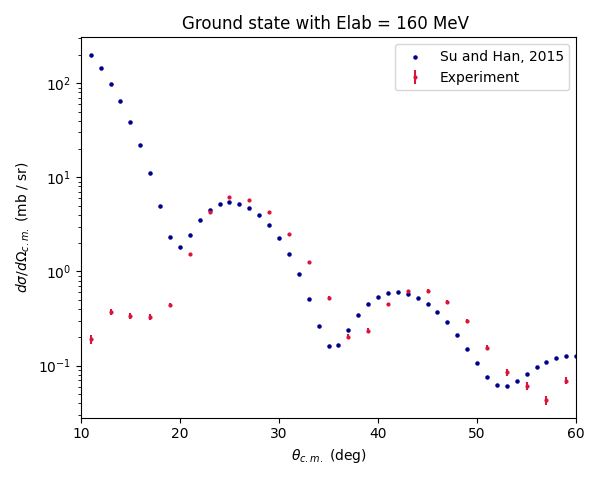

In [19]:
import pandas as pd

cross_sections = {}

for idx,energy in enumerate(energy_at_halfway):
    file_path = f"/Users/pranjalsingh/Desktop/research_space_spyral/Su_Han_calculations/DWBA.Xsec_{energy:.2f}.txt"
    df = pd.read_csv(file_path, sep='\s+', skiprows=2) 
    if idx == 0:
        cross_sections["angles_cm"] = df.iloc[:, 0].values
        cross_sections[f"xsec_{energy:.2f}"] = df.iloc[:, 1].values * percentage_slice[idx]
    
    else:
        cross_sections[f"xsec_{energy:.2f}"] = df.iloc[:, 1].values * percentage_slice[idx]
    

cs_df = pd.DataFrame(cross_sections)
cs_df

cs_df['average_cross_sections'] = (cs_df.iloc[:, 1:].mean(axis=1))/(sum(percentage_slice))

angle = cs_df["angles_cm"].to_numpy().astype(float)
xsec = cs_df['average_cross_sections'].to_numpy().astype(float)

fig, ax = plt.subplots(1, 1)
ax.scatter(angle[10:], xsec[10:],label = "Su and Han, 2015",s=5,color="darkblue")
ax.set_yscale("log")

ax.errorbar(cm_hist.bins[:-1]+cm_hist.bin_width/2, xs, yerr=xs_err, c="crimson",fmt='o', markersize=2,label="Experiment")

ax.set_title(f"Ground state with Elab = {proj_energy_start} MeV ")
ax.set_xlabel(r"$\theta_{c.m.}$ (deg)")
ax.set_ylabel(r"$d\sigma / d\Omega_{c.m.}$ (mb / sr)")

plt.xlim(min_cm, max_cm)
# plt.ylim(0,5e2)
ax.legend()
fig.set_figwidth(8.0)
fig.set_figwidth(6.0)
fig.tight_layout()
